## Modelo predictivo para determinar clientes buenos y malos en base a su comportamiento interno y externo

### **0.-Importamos las librerías a usar**

In [122]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import gc
import lightgbm as lgb
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
from sklearn.impute import SimpleImputer
from statistics import mode 


In [2]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

Using TensorFlow backend.
C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\avela

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## **1.Leer los datos del dataset**
### Leer los datos del dataset

In [921]:
datos = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF6.xlsx")

### Identifique número de filas y columnas

In [922]:
print("Número de filas : ",str(datos.shape[0]),"y Número de columnas : " ,str(datos.shape[1]))

Número de filas :  142451 y Número de columnas :  40


## **2.Frecuencia Inicial**
Determinar la frecuencia de BUENOS y MALOS en los datos, de tal forma que se puede armar muestras. Calcule el nivel de entropía e interprete los resultados.

In [923]:
pd.value_counts(datos['FlagCliente'])

BUEN CLIENTE    133674
MAL CLIENTE       8777
Name: FlagCliente, dtype: int64

In [924]:
100 * datos['FlagCliente'].value_counts() / len(datos['FlagCliente'])

BUEN CLIENTE    93.838583
MAL CLIENTE      6.161417
Name: FlagCliente, dtype: float64

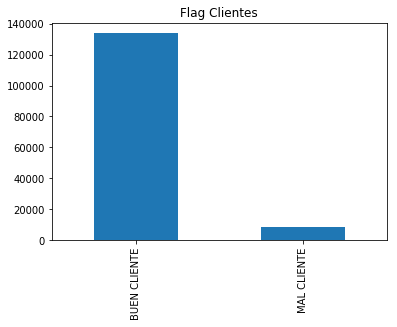

In [925]:
plot = datos['FlagCliente'].value_counts().plot(kind='bar',
                                            title='Flag Clientes')


## **3. Descripción y transformación de los datos**
Preparar la descripción de los datos, con estadística Univariada y multivarida, exponer los atributos en función al ranking de atributos, primero el más importante. Solo con los datos balanceados.

In [926]:
df_train=datos.copy()

In [927]:
df_train

,idencuenta,numdoc,sexo,edad,estadocivil,departamento,s_fin_estab,s_rev_estab,s_fin_atm,s_rev_atm,...,ConsumoAnual201806_201906,NroTransaccionAnual201806_201906,tipo_seguro,HabitoPago201901,HabitoPago201902,HabitoPago201903,HabitoPago201906,HabitoPago201904,HabitoPago201905,FlagCliente
0,5,10307110,F,43,SOLTERO ...,Lima,517.73,942.91,0.0,0.00,...,16622.82,92.0,PARTICULARES,4,4,3,4,4,4,BUEN CLIENTE
1,6,44970275,F,32,SOLTERO ...,Lima,0.00,1165.43,0.0,-3.11,...,13140.13,70.0,ESSALUD,4,4,4,5,5,5,BUEN CLIENTE
2,10,45150787,M,31,SOLTERO ...,Arequipa,751.31,1072.64,0.0,0.00,...,11481.89,64.0,PARTICULARES,5,5,5,5,5,5,BUEN CLIENTE
3,14,46687550,M,28,SOLTERO ...,Lima,0.00,48.92,0.0,0.00,...,1332.98,21.0,PARTICULARES,-1,5,5,-1,5,5,BUEN CLIENTE
4,29,2825184,F,47,CASADO ...,Lima,0.00,718.75,0.0,0.00,...,3174.79,17.0,ONCOSALUD,5,5,5,5,5,5,BUEN CLIENTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142446,307368,9020879,M,63,CASADO ...,Lima,1657.00,0.00,0.0,0.00,...,NaN,NaN,ESSALUD,-1,-1,-1,-1,-1,-1,BUEN CLIENTE
142447,307832,25658008,M,54,CASADO ...,Callao,1499.00,0.00,0.0,0.00,...,NaN,NaN,ESSALUD,-1,-1,-1,-1,-1,-1,BUEN CLIENTE
142448,307845,8275826,F,50,CASADO ...,Lima,4798.00,0.00,0.0,0.00,...,NaN,NaN,EPS,-1,-1,-1,-1,-1,-1,BUEN CLIENTE
142449,307847,45978696,F,29,CASADO ...,Lima,1147.00,0.00,0.0,0.00,...,NaN,NaN,ONCOSALUD,-1,-1,-1,-1,-1,-1,BUEN CLIENTE


In [140]:
#CONVERTIR DATOS Enteros a Categóricos
#df_train['Flag_usoApp'] = df_train['Flag_usoApp'].astype(str) 
#df_train['Flg_sRefinanciamiento201906'] = df_train['Flg_sRefinanciamiento201906'].astype(str)
#df_train['Flg_sRefinanciamiento201909'] = df_train['Flg_sRefinanciamiento201909'].astype(str) 
#df_train['Flg_sRefinanciamiento201912'] = df_train['Flg_sRefinanciamiento201912'].astype(str) 

#df_train['FlagCBCuotasSemestral'] = df_train['FlagCBCuotasSemestral'].astype(str) 
#df_train['FlagCBCuotasAnual'] = df_train['FlagCBCuotasAnual'].astype(str) 
#df_train['FlagCasino'] = df_train['FlagCasino'].astype(str)
#df_train['FlagSaldoCASTIGADO'] = df_train['FlagSaldoCASTIGADO'].astype(str) 

In [928]:
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [929]:
#TRANSFORMACIÓN DE LAS VARIABLES
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train.loc[df_train[l].notnull(),l]=df_train.loc[df_train[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train[l].dropna())+list(df_train[l].dropna()))
    
    df_train.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [415]:
#pd.value_counts(df_train["TIPO_GRADO"])

In [930]:
#Creamos una función:
def num_missing(x):
  return sum(x.isnull())
#Aplicamos por columna:
print ("Valores perdidos por columna")
dict(df_train.apply(num_missing, axis=0)) 
#df_train["TIPO_GRADO"]=df_train["TIPO_GRADO"].fillna(value=5)


Valores perdidos por columna


{'idencuenta': 0,
 'numdoc': 0,
 'sexo': 0,
 'edad': 0,
 'estadocivil': 0,
 'departamento': 0,
 's_fin_estab': 0,
 's_rev_estab': 0,
 's_fin_atm': 0,
 's_rev_atm': 0,
 'saldo_lp': 0,
 'saldo_mora': 0,
 'saldo_exceso': 0,
 'DiasMora201906': 0,
 'estado': 0,
 'nombre_producto': 0,
 'linea_credito_usd': 0,
 'linea_credito_soles': 0,
 'flg_situacionlaboral_oscar': 0,
 'porc_uso_linea': 0,
 'flg_ppd': 0,
 'flg_usodisef': 0,
 'zona_apein': 0,
 'maxlinea_bench': 0,
 'flagscastigado': 0,
 'flagrefinanciado': 0,
 'flagpld': 0,
 'flagdiseftcexterno': 0,
 'FLGRCC': 0,
 'segmentoNSE': 0,
 'ConsumoAnual201806_201906': 9229,
 'NroTransaccionAnual201806_201906': 9229,
 'tipo_seguro': 0,
 'HabitoPago201901': 0,
 'HabitoPago201902': 0,
 'HabitoPago201903': 0,
 'HabitoPago201906': 0,
 'HabitoPago201904': 0,
 'HabitoPago201905': 0,
 'FlagCliente': 0}

In [931]:
df_train["ConsumoAnual201806_201906"]=df_train["ConsumoAnual201806_201906"].fillna(value = 0) 
df_train["NroTransaccionAnual201806_201906"] = df_train["NroTransaccionAnual201806_201906"].fillna(value = 0)

## Primera ejecución del modelo

In [932]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=["bueno", "malo"], yticklabels=["bueno","malo"], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
    

In [933]:
y = df_train['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X = df_train.drop(remover, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 1970)

In [934]:
colsP = X.columns.to_list()

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


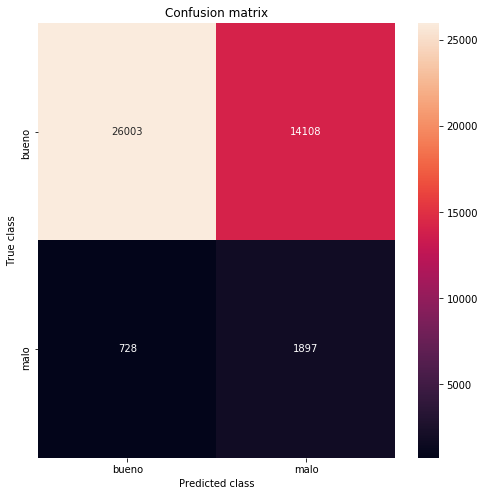

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     40111
           1       0.12      0.72      0.20      2625

    accuracy                           0.65     42736
   macro avg       0.55      0.69      0.49     42736
weighted avg       0.92      0.65      0.74     42736



In [935]:
colsP = X.columns.to_list()
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter= 500, class_weight= "balanced")
logit.fit(X_train, y_train)
 
# Test accuracy
y_pred = logit.predict(X_test)

mostrar_resultados(y_test, y_pred)

## 3.1 Boruta para la selección de variables

In [936]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [943]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 90)
boruta_feature_selector.fit(X.values, y.values)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	34
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 50
Confirmed: 	34
Tentative: 	0
Rejected: 	3


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=172, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x25E0E110EB8,
                                          verbose=0, warm_start=F

##### validacion

In [944]:
X_filtered = boruta_feature_selector.transform(X.values)
cols = X_train.columns[boruta_feature_selector.support_]
cols

Index(['sexo', 'edad', 's_fin_estab', 's_rev_estab', 's_fin_atm', 's_rev_atm',
       'saldo_lp', 'saldo_mora', 'DiasMora201906', 'estado', 'nombre_producto',
       'linea_credito_usd', 'linea_credito_soles',
       'flg_situacionlaboral_oscar', 'porc_uso_linea', 'flg_ppd',
       'flg_usodisef', 'zona_apein', 'maxlinea_bench', 'flagscastigado',
       'flagrefinanciado', 'flagpld', 'flagdiseftcexterno', 'FLGRCC',
       'segmentoNSE', 'ConsumoAnual201806_201906',
       'NroTransaccionAnual201806_201906', 'tipo_seguro', 'HabitoPago201901',
       'HabitoPago201902', 'HabitoPago201903', 'HabitoPago201906',
       'HabitoPago201904', 'HabitoPago201905'],
      dtype='object')

In [945]:
len(cols)

34

### Variables descartadas por el algoritmo boruta

In [946]:
descarteBoruta =[x for x in colsP if x not in cols]
descarteBoruta

['estadocivil', 'departamento', 'saldo_exceso']

## 4. Balance de datos con SMOTETomek
### Debido a la relación entre clientes buenos y malos, es necesario realizar un balanceo de los datos
   SMOTETomek, es un método de balance de datos basado en el subsampling y el oversampling

In [947]:
#Balanceo
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_sample(X_train[cols], y_train.ravel())

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 93563, 1: 6152})
Distribution of class labels after resampling Counter({1: 92508, 0: 92508})


## Segunda ejecución del modelo

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


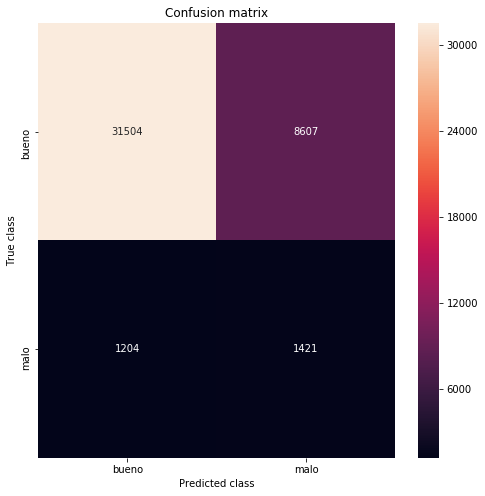

              precision    recall  f1-score   support

           0       0.96      0.79      0.87     40111
           1       0.14      0.54      0.22      2625

    accuracy                           0.77     42736
   macro avg       0.55      0.66      0.54     42736
weighted avg       0.91      0.77      0.83     42736



In [948]:
from sklearn.linear_model import LogisticRegression
est_boruta = LogisticRegression(max_iter= 500)
est_boruta.fit(X_train_res, y_train_res)
 
# Test accuracy
y_pred = est_boruta.predict(X_test[cols])

mostrar_resultados(y_test, y_pred)

In [949]:
sklearn.metrics.cohen_kappa_score(y_test, y_pred)

0.14097499500544575

In [950]:
roc_auc_score(y_test, y_pred)

0.6633768957808747

Conclusión: La precisión del modelo es del 71%, procederemos a evaluar la correlación entre variables ya que el algoritmo boruta puede no haber eliminado las variables con mayor peso

## 5. Análisis de variables
### 5.1 Matriz de correlación

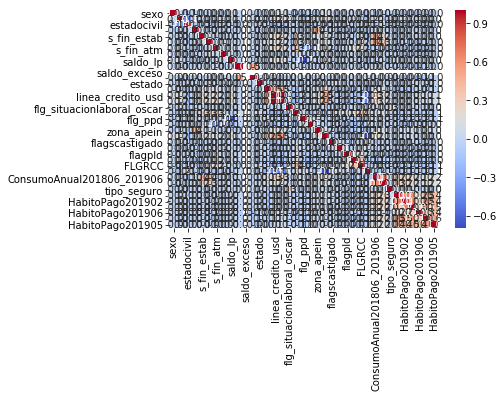

In [951]:
data = df_train.copy()
sns.heatmap(data[colsP].corr(),annot=True,fmt="0.1f",cmap="coolwarm")
plt.show()
data3 = data[colsP].copy()
data3['FlagCliente'] = data['FlagCliente']

In [787]:
data3 = data[colsP].copy()
data3['FlagCliente'] = data['FlagCliente']

In [952]:
df_matrix_num = data3.corr()
#df_matrix_num.to_csv("correlation.csv")
df_matrix_num

,sexo,edad,estadocivil,departamento,s_fin_estab,s_rev_estab,s_fin_atm,s_rev_atm,saldo_lp,saldo_mora,...,ConsumoAnual201806_201906,NroTransaccionAnual201806_201906,tipo_seguro,HabitoPago201901,HabitoPago201902,HabitoPago201903,HabitoPago201906,HabitoPago201904,HabitoPago201905,FlagCliente
sexo,1.000000,0.030324,-0.098352,-0.020280,-0.021138,0.026577,0.046595,0.003979,0.069233,0.006585,...,0.006230,0.000713,-0.029795,-0.009212,-0.007662,-0.007679,-0.002917,-0.012082,-0.006684,0.027303
edad,0.030324,1.000000,-0.425247,0.019623,0.037253,0.016956,0.058223,0.002571,0.055303,0.003980,...,0.040383,-0.014051,0.005243,0.053640,0.036606,0.034102,0.005519,0.031480,0.024377,-0.016057
estadocivil,-0.098352,-0.425247,1.000000,-0.001551,-0.052644,-0.043284,-0.027042,0.002046,-0.034562,-0.011298,...,-0.068190,-0.018761,-0.001102,-0.019259,-0.012669,-0.015685,-0.003135,-0.013499,-0.009843,0.008146
departamento,-0.020280,0.019623,-0.001551,1.000000,0.034084,0.033889,-0.002019,0.000073,-0.008769,0.006398,...,0.049957,0.038268,0.014039,0.006801,0.006088,0.006872,0.000232,0.006251,0.006712,-0.008832
s_fin_estab,-0.021138,0.037253,-0.052644,0.034084,1.000000,0.063898,-0.003720,-0.016165,0.004721,0.036390,...,0.441105,0.172513,0.012222,0.019006,0.022311,0.026356,0.008649,0.038136,0.032678,-0.016579
s_rev_estab,0.026577,0.016956,-0.043284,0.033889,0.063898,1.000000,0.007088,0.103977,-0.014112,0.057277,...,0.429370,0.337874,0.010194,0.002981,-0.007625,-0.008100,-0.064313,-0.020772,-0.036494,0.026315
s_fin_atm,0.046595,0.058223,-0.027042,-0.002019,-0.003720,0.007088,1.000000,0.009947,0.098672,0.033312,...,-0.013927,-0.025330,-0.011566,-0.026540,-0.020834,-0.014897,-0.036634,-0.012323,-0.014840,0.087595
s_rev_atm,0.003979,0.002571,0.002046,0.000073,-0.016165,0.103977,0.009947,1.000000,-0.002125,-0.010410,...,0.043819,0.001289,0.000543,-0.009285,-0.009085,-0.010948,-0.013836,-0.007751,-0.007613,0.023884
saldo_lp,0.069233,0.055303,-0.034562,-0.008769,0.004721,-0.014112,0.098672,-0.002125,1.000000,0.020264,...,0.009795,-0.012050,-0.012527,0.029039,0.029875,0.028063,0.040180,0.031497,0.034871,0.002251
saldo_mora,0.006585,0.003980,-0.011298,0.006398,0.036390,0.057277,0.033312,-0.010410,0.020264,1.000000,...,0.036536,0.013088,0.009417,-0.001708,-0.007500,-0.001031,-0.073223,-0.018332,-0.013971,0.049194


In [953]:
#Correlación de varaibles con el FlagCliente, evaluadas de manera independiente
df_var_num=pd.DataFrame({'VARIABLES':data3.columns.values,'FlagCliente':df_matrix_num.FlagCliente}).sort_values(['FlagCliente'], ascending=[0])
df_var_num.values

array([['FlagCliente', 1.0],
       ['FLGRCC', 0.15811391614748826],
       ['porc_uso_linea', 0.1544586864350811],
       ['flagdiseftcexterno', 0.10559816711170089],
       ['DiasMora201906', 0.10256537368098202],
       ['s_fin_atm', 0.08759511890030945],
       ['segmentoNSE', 0.07574804112320237],
       ['flagpld', 0.060624557014805375],
       ['flagscastigado', 0.06041673926250767],
       ['flg_situacionlaboral_oscar', 0.054071222930898305],
       ['flagrefinanciado', 0.050789584211978614],
       ['saldo_mora', 0.04919395397430701],
       ['sexo', 0.027302854012389677],
       ['s_rev_estab', 0.026314871933574815],
       ['s_rev_atm', 0.023883712518359402],
       ['estadocivil', 0.00814601894230787],
       ['estado', 0.007918449333987458],
       ['tipo_seguro', 0.0037833625376521222],
       ['saldo_lp', 0.0022509220251354534],
       ['flg_ppd', -0.005936971853794682],
       ['departamento', -0.00883212211625237],
       ['edad', -0.016057345160947745],
       ['s_fin

### 5.2 Elimino variables redundantes con correlación > 95%

In [954]:
cols2 = data3.columns.to_list()
#lista = ["edad","LineaCDolares201906"]
#for x in lista:
 #   cols2.remove(x)
cols2

['sexo',
 'edad',
 'estadocivil',
 'departamento',
 's_fin_estab',
 's_rev_estab',
 's_fin_atm',
 's_rev_atm',
 'saldo_lp',
 'saldo_mora',
 'saldo_exceso',
 'DiasMora201906',
 'estado',
 'nombre_producto',
 'linea_credito_usd',
 'linea_credito_soles',
 'flg_situacionlaboral_oscar',
 'porc_uso_linea',
 'flg_ppd',
 'flg_usodisef',
 'zona_apein',
 'maxlinea_bench',
 'flagscastigado',
 'flagrefinanciado',
 'flagpld',
 'flagdiseftcexterno',
 'FLGRCC',
 'segmentoNSE',
 'ConsumoAnual201806_201906',
 'NroTransaccionAnual201806_201906',
 'tipo_seguro',
 'HabitoPago201901',
 'HabitoPago201902',
 'HabitoPago201903',
 'HabitoPago201906',
 'HabitoPago201904',
 'HabitoPago201905',
 'FlagCliente']

## 5.3 Information Value
#### El valor de la información es  útil para la selección de variables durante la construcción de modelos de clasificación binaria

   #### Valor informativo - >	Poder de predicción
          <0.02	 Inútil para la predicción
     0.02 a 0.1     Pronosticador débil
      0.1 a 0.3     Predictor medio
      0.3 a 0.5	 Fuerte predictor 
          > 0.5     Sospechoso o demasiado bueno para ser verdad

In [955]:
import scorecardpy as sc
df_data = data3.copy()
df_filter = sc.var_filter(df_data, y="FlagCliente")

[INFO] filtering variables ...
Variable filtering on 142451 rows and 38 columns in 00:03:18 
10 variables are removed


12 variables han sido removidas por tener un peso menor a 0.02

In [956]:
# Obtener el information Value por cada variable para conocer la importancia
dt_info_value = sc.iv(df_filter, y = "FlagCliente")
#Se muestra el information value por cada variable en forma descendente
dt_info_value.values

array([['s_fin_atm', 1.5794841886749775],
       ['maxlinea_bench', 1.3972273210967674],
       ['saldo_lp', 1.324182685267122],
       ['s_rev_estab', 0.8928200445491301],
       ['s_fin_estab', 0.7489473272855351],
       ['porc_uso_linea', 0.613653202147418],
       ['s_rev_atm', 0.5540653451287005],
       ['HabitoPago201906', 0.5039102916248805],
       ['FLGRCC', 0.3992855948956259],
       ['linea_credito_usd', 0.3962852785578807],
       ['linea_credito_soles', 0.39628527855787987],
       ['ConsumoAnual201806_201906', 0.27004830456633805],
       ['HabitoPago201904', 0.237660915984734],
       ['NroTransaccionAnual201806_201906', 0.23444710628364815],
       ['HabitoPago201903', 0.2019353272054811],
       ['HabitoPago201905', 0.1992521569900066],
       ['HabitoPago201902', 0.18317164526736285],
       ['flagdiseftcexterno', 0.16645981431229512],
       ['HabitoPago201901', 0.14864154707823257],
       ['flg_usodisef', 0.11262466608170217],
       ['segmentoNSE', 0.0942748516

In [521]:
dt_list = list()
for i in  dt_info_value.values:
    dt_list.append(i[0])
dt_list

['FlagHabitoPago3M',
 'FlagHabitoPago6M',
 'HabitoPago201906',
 'HabitoPago201905',
 'HabitoPago201904',
 'HabitoPago201903',
 'SaldoTotal201906',
 'HabitoPago201902',
 'Flg_SBS201906',
 'flg_Socio_CSI',
 'HabitoPago201901',
 'Flg_usoRCC201906',
 'ConsumoAnual201806_201906',
 'NroTransaccionAnual201806_201906',
 'SEGMENTONSE',
 'Cant_Adicionales_Entregadas',
 'FlagDisefTcExterno',
 'Flg_usoDisef201906',
 'Nombre_Producto',
 'tipo_seguro',
 'FlgSituacionLaboral',
 'FlagPLD',
 'zona_apein']

In [38]:
dt_list2 = list()
for i in  dt_info_value.values:
    dt_list2.append(i[1])


In [95]:
graf = {"variable":dt_list, "peso": dt_list2}
grafE = pd.DataFrame(graf)
grafE.to_excel("p.xlsx")

## Variables descartadas

In [594]:
descarteBoruta

['estadocivil', 'departamento', 'saldo_exceso', 'flg_ppd']

In [725]:
descarteIV =[x for x in cols2 if x not in dt_list]
descarteIV

['sexo',
 'edad',
 'estadocivil',
 'departamento',
 's_fin_estab',
 's_rev_estab',
 's_fin_atm',
 's_rev_atm',
 'saldo_lp',
 'saldo_mora',
 'saldo_exceso',
 'DiasMora201906',
 'estado',
 'nombre_producto',
 'linea_credito_usd',
 'linea_credito_soles',
 'flg_situacionlaboral_oscar',
 'porc_uso_linea',
 'flg_ppd',
 'flg_usodisef',
 'maxlinea_bench',
 'flagscastigado',
 'flagrefinanciado',
 'flagpld',
 'flagdiseftcexterno',
 'FLGRCC',
 'segmentoNSE',
 'FlagCliente']

In [957]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 0.5]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4

print(features)
len(features)

['FLGRCC', 'linea_credito_usd', 'linea_credito_soles', 'ConsumoAnual201806_201906', 'HabitoPago201904', 'NroTransaccionAnual201806_201906', 'HabitoPago201903', 'HabitoPago201905', 'HabitoPago201902', 'flagdiseftcexterno', 'HabitoPago201901', 'flg_usodisef', 'segmentoNSE', 'tipo_seguro', 'nombre_producto', 'flagpld', 'zona_apein', 'flg_situacionlaboral_oscar', 'edad']


19

In [958]:
#Balanceo
os_us = SMOTETomek( random_state= 2)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 93563, 1: 6152})
Distribution of class labels after resampling Counter({1: 89871, 0: 89871})


#### Ejecución del modelo 

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


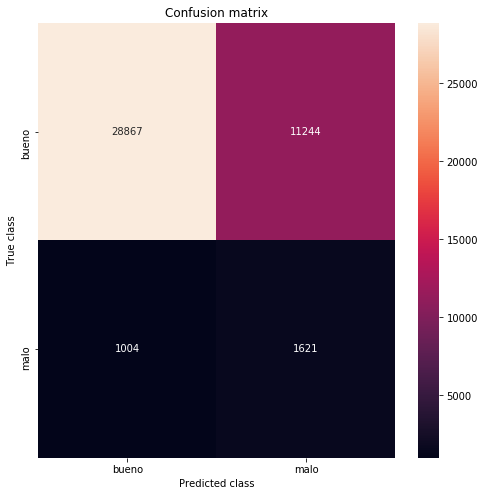

              precision    recall  f1-score   support

           0       0.97      0.72      0.82     40111
           1       0.13      0.62      0.21      2625

    accuracy                           0.71     42736
   macro avg       0.55      0.67      0.52     42736
weighted avg       0.91      0.71      0.79     42736



array([[28867, 11244],
       [ 1004,  1621]], dtype=int64)

In [959]:
from sklearn.linear_model import LogisticRegression
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res)
 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])

mostrar_resultados(y_test, y_pred)
confusion_matrix(y_test, y_pred)

### 5.3.1 Elimino las variables cuyo índice es mayor a 1.2
   #### Las variables con peso > 1 serán removidas para evaluar las que se encuentran en el rango <0.02 - 1> 

In [794]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 1 ]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

24

In [795]:
#Balanceo
os_us = SMOTETomek( random_state= 2)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 93563, 1: 6152})
Distribution of class labels after resampling Counter({1: 91638, 0: 91638})


## Tercera ejecución del modelo

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


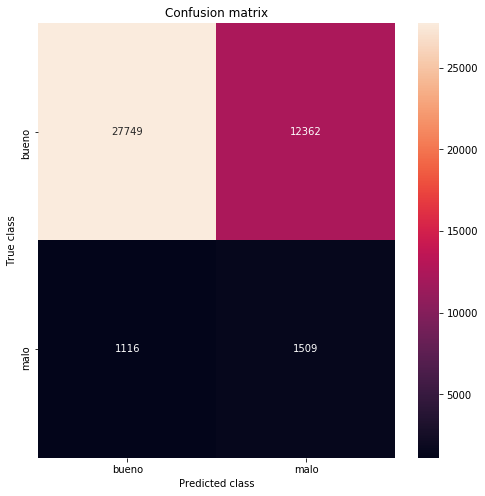

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     40111
           1       0.11      0.57      0.18      2625

    accuracy                           0.68     42736
   macro avg       0.54      0.63      0.49     42736
weighted avg       0.91      0.68      0.77     42736



array([[27749, 12362],
       [ 1116,  1509]], dtype=int64)

In [796]:
from sklearn.linear_model import LogisticRegression
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res)
 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])

mostrar_resultados(y_test, y_pred)
confusion_matrix(y_test, y_pred)

Conclusión: Las variables removidas no disminuyen o aumentan
 la precisión del modelo, por ende se removerán las variables cuyo IV es mayor que 0.75

### 5.3.2 Elimino las variables cuyo índice es mayor a 0.75
   #### Las variables con peso > 0.75 serán removidas para evaluar las que se encuentran en el rango <0.02 - 0.75> 

In [797]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 0.75 ]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

23

In [798]:
#Balanceo
os_us = SMOTETomek(random_state=2)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 93563, 1: 6152})
Distribution of class labels after resampling Counter({1: 90748, 0: 90748})


## Cuarta ejecución del modelo

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


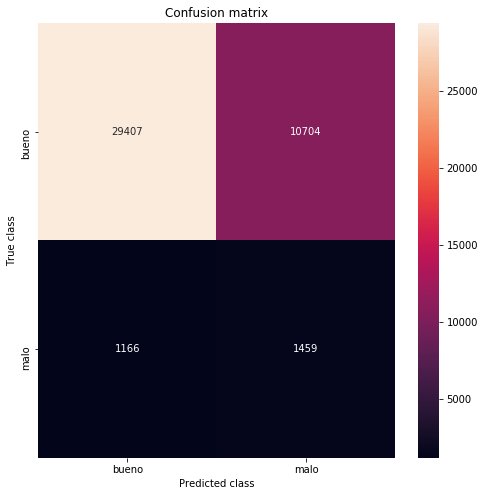

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     40111
           1       0.12      0.56      0.20      2625

    accuracy                           0.72     42736
   macro avg       0.54      0.64      0.51     42736
weighted avg       0.91      0.72      0.79     42736



In [799]:
from sklearn.linear_model import LogisticRegression
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res)
 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])

mostrar_resultados(y_test, y_pred)

Conclusión: la precisión disminuye hasta 70%

### 5.3.3 Elimino las variables cuyo índice es mayor a 0.55
   #### Las variables con peso > 0.55 serán removidas para evaluar las que se encuentran en el rango <0.02 - 0.55> 

In [807]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 0.555 ]

cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

21

In [809]:
features

['s_rev_atm',
 'HabitoPago201906',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201806_201906',
 'HabitoPago201904',
 'NroTransaccionAnual201806_201906',
 'HabitoPago201903',
 'HabitoPago201905',
 'HabitoPago201902',
 'flagdiseftcexterno',
 'HabitoPago201901',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [801]:
#Balanceo
os_us =  SMOTETomek(random_state=3)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

## Quinta ejecución del modelo

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


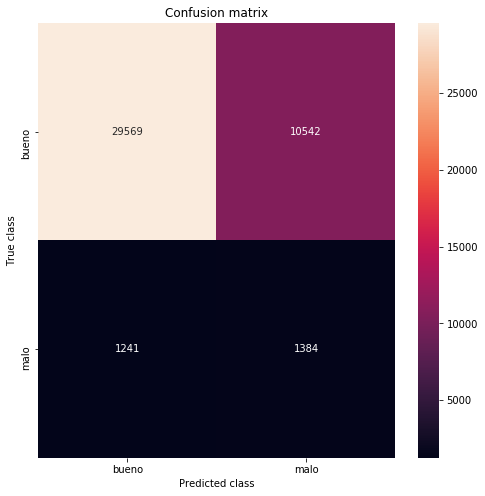

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     40111
           1       0.12      0.53      0.19      2625

    accuracy                           0.72     42736
   macro avg       0.54      0.63      0.51     42736
weighted avg       0.91      0.72      0.79     42736



In [802]:
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res) 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])
mostrar_resultados(y_test, y_pred)

Conclusión: la precisión se mantiene 

### 5.3.4 Elimino las variables cuyo índice es mayor a 0.45
   #### Las variables con peso > 0.45 serán removidas para evaluar las que se encuentran en el rango <0.02 - 0.45> 

In [810]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <=0.52]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

20

In [811]:
features


['HabitoPago201906',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201806_201906',
 'HabitoPago201904',
 'NroTransaccionAnual201806_201906',
 'HabitoPago201903',
 'HabitoPago201905',
 'HabitoPago201902',
 'flagdiseftcexterno',
 'HabitoPago201901',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [812]:
#Balanceo
os_us =  SMOTETomek(random_state= 5)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

## Sexta ejecución del modelo

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


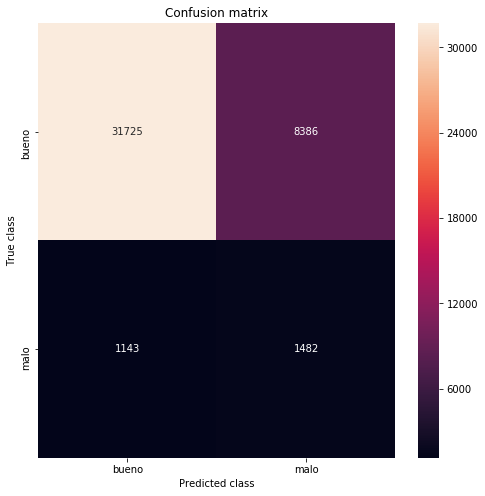

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     40111
           1       0.15      0.56      0.24      2625

    accuracy                           0.78     42736
   macro avg       0.56      0.68      0.55     42736
weighted avg       0.92      0.78      0.83     42736



In [813]:
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res) 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])
mostrar_resultados(y_test, y_pred)

Conclusión: la precisión disminuye debido a que hemos removido variables consideradas como fuertes predictoras

Conclusión 2: trabajaremos con el rango <0.02 - 0.55> cuya precisión es de 76%

## ANÁLISIS DE VARIABLES REMOVIDAS

In [724]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 3]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

28

In [748]:
descarteBoruta

['estadocivil', 'departamento', 'saldo_exceso', 'flg_ppd', 'flagrefinanciado']

In [749]:
descarteIV

['sexo',
 'edad',
 'estadocivil',
 'departamento',
 's_fin_estab',
 's_rev_estab',
 's_fin_atm',
 's_rev_atm',
 'saldo_lp',
 'saldo_mora',
 'saldo_exceso',
 'DiasMora201906',
 'estado',
 'nombre_producto',
 'linea_credito_usd',
 'linea_credito_soles',
 'flg_situacionlaboral_oscar',
 'porc_uso_linea',
 'flg_ppd',
 'flg_usodisef',
 'maxlinea_bench',
 'flagscastigado',
 'flagrefinanciado',
 'flagpld',
 'flagdiseftcexterno',
 'FLGRCC',
 'segmentoNSE',
 'FlagCliente']

In [727]:
feat = features # + features[6:] #+ descarteIV[:-1]#+ descarteIV[:5]+ descarteIV[-7:-1] ##descarteIV[-11:-1] + descarteIV[:5]

feat

['S_FIN_ATM201906',
 'SaldoLP201906',
 'MaxLineaBench201906',
 'S_REV_ATM201906',
 'S_REV_ESTAB201906',
 's_fin_estab201906',
 'LineaCDolares01906',
 'LineaCSoles201906',
 'Flg_usoRCC201906',
 'NroTransaccionAnual201806_201906',
 'flg_Socio_CSI',
 'HabitoPago201906',
 'SaldoTotal201906',
 'Flg_SBS201906',
 'HabitoPago201905',
 'HabitoPago201904',
 'Flg_usoDisef201906',
 'HabitoPago201903',
 'HabitoPago201902',
 'HabitoPago201901',
 'ConsumoAnual201806_201906',
 'Cant_Adicionales_Entregadas',
 'tipo_seguro',
 'Nombre_Producto',
 'SEGMENTONSE',
 'FlgSituacionLaboral',
 'zona_apein',
 'edad']

In [121]:
ran = ""
for i in features:
    ran += i + ", "
    
print (ran)    

Flg_usoRCC201906, NroTransaccionAnual201806_201906, flg_Socio_CSI, HabitoPago201906, SaldoTotal201906, Flg_SBS201906, HabitoPago201905, HabitoPago201904, Flg_usoDisef201906, HabitoPago201903, HabitoPago201902, HabitoPago201901, ConsumoAnual201806_201906, Cant_Adicionales_Entregadas, tipo_seguro, Nombre_Producto, SEGMENTONSE, FlgSituacionLaboral, zona_apein, edad, 


In [728]:
#Balanceo
os_us = SMOTETomek(random_state=2)
X_train_res, y_train_res = os_us.fit_sample(X_train[feat], y_train.ravel())

## Séptima ejecución del modelo

In [517]:
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res) 
# Test accuracy
y_pred = est_boruta.predict(X_test[feat])
mostrar_resultados(y_test, y_pred)

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


NameError: name 'feat' is not defined

 1 variable 74%
 
 2 variables 71%
 
 4 primeras variables 67%
 
 5 variables 75%
 
 ----
 Variables entre 0.02 --> 0.50
 
 23 variables 72%
 
 train -  [142001   9503]   |   test -  [35501  2375]
 
train -  [142001   9503]   |   test -  [35501  2375]

train -  [142002   9502]   |   test -  [35500  2376]

train -  [142002   9502]   |   test -  [35500  2376]

train -  [142002   9502]   |   test -  [35500  2376]
 


## Validación cruzada

In [816]:
X.columns

Index(['sexo', 'edad', 'estadocivil', 'departamento', 's_fin_estab',
       's_rev_estab', 's_fin_atm', 's_rev_atm', 'saldo_lp', 'saldo_mora',
       'saldo_exceso', 'DiasMora201906', 'estado', 'nombre_producto',
       'linea_credito_usd', 'linea_credito_soles',
       'flg_situacionlaboral_oscar', 'porc_uso_linea', 'flg_ppd',
       'flg_usodisef', 'zona_apein', 'maxlinea_bench', 'flagscastigado',
       'flagrefinanciado', 'flagpld', 'flagdiseftcexterno', 'FLGRCC',
       'segmentoNSE', 'ConsumoAnual201806_201906',
       'NroTransaccionAnual201806_201906', 'tipo_seguro', 'HabitoPago201901',
       'HabitoPago201902', 'HabitoPago201903', 'HabitoPago201906',
       'HabitoPago201904', 'HabitoPago201905'],
      dtype='object')

In [960]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <=0.53]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4
len(features)

20

In [961]:
X1 = X[features].copy()
y1 = y.copy()
x_test = X1.copy

1 of KFold 5
ROC AUC score: 0.6726026215936529
KAPPA:  0.14483522252068715


C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


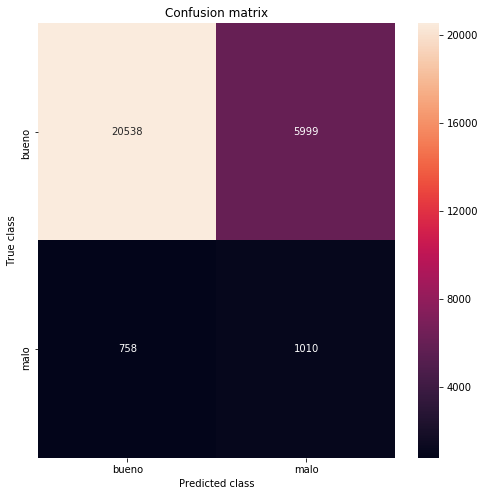

              precision    recall  f1-score   support

           0       0.96      0.77      0.86     26537
           1       0.14      0.57      0.23      1768

    accuracy                           0.76     28305
   macro avg       0.55      0.67      0.54     28305
weighted avg       0.91      0.76      0.82     28305

2 of KFold 5
ROC AUC score: 0.6663419507161263
KAPPA:  0.141652541761648


C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


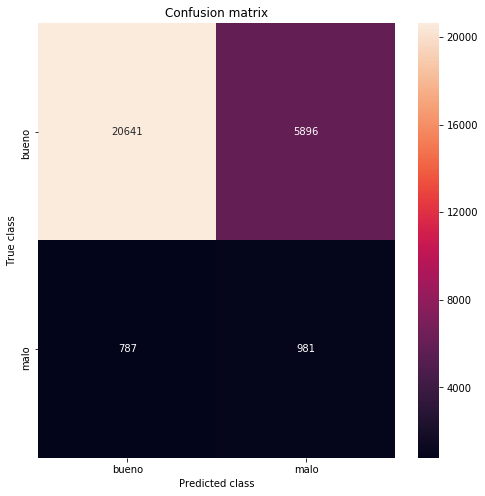

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     26537
           1       0.14      0.55      0.23      1768

    accuracy                           0.76     28305
   macro avg       0.55      0.67      0.54     28305
weighted avg       0.91      0.76      0.82     28305

3 of KFold 5
ROC AUC score: 0.6599325212052433
KAPPA:  0.13767936764373623


C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


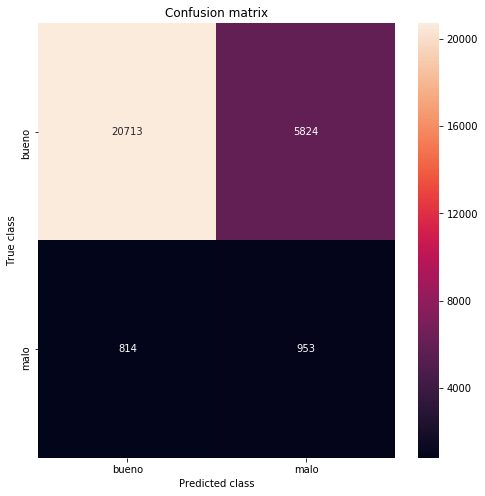

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     26537
           1       0.14      0.54      0.22      1767

    accuracy                           0.77     28304
   macro avg       0.55      0.66      0.54     28304
weighted avg       0.91      0.77      0.82     28304

4 of KFold 5
ROC AUC score: 0.682731411368936
KAPPA:  0.14751221521149283


C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


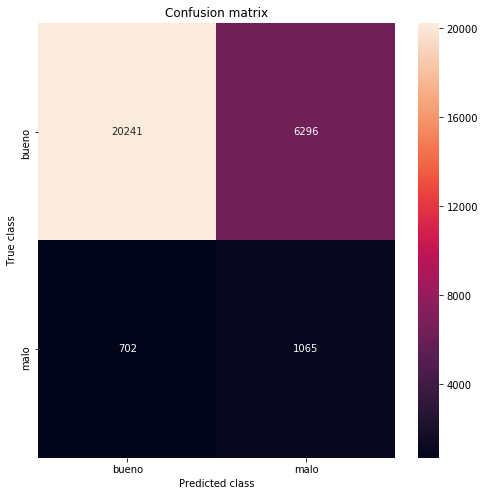

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     26537
           1       0.14      0.60      0.23      1767

    accuracy                           0.75     28304
   macro avg       0.56      0.68      0.54     28304
weighted avg       0.92      0.75      0.81     28304

5 of KFold 5
ROC AUC score: 0.6581566321245546
KAPPA:  0.13819296897366107


C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


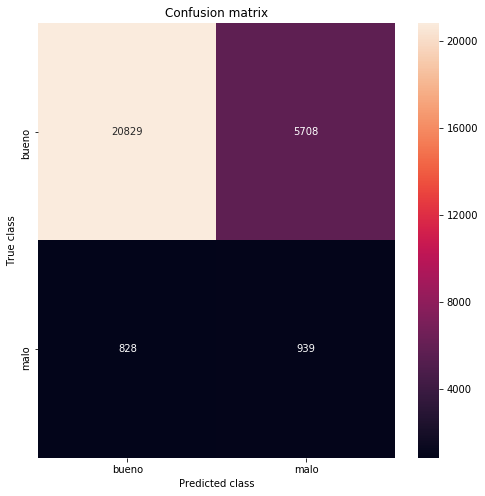

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     26537
           1       0.14      0.53      0.22      1767

    accuracy                           0.77     28304
   macro avg       0.55      0.66      0.54     28304
weighted avg       0.91      0.77      0.82     28304

Promedio auc score:  0.6679530274017026


In [977]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state= 2010)
pred_test_full =0
cv_score =[]
i=1
lr = LogisticRegression()
for train_index,test_index in kf.split(X1,y1):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X1.loc[train_index],X1.loc[test_index]
    ytr,yvl = y1.loc[train_index],y1.loc[test_index]
    
    #Balanceo
    os_us = SMOTETomek(random_state=2)
    #X_train_res, y_train_res = os_us.fit_sample(xtr,ytr.ravel())
    X_train_res, y_train_res = os_us.fit_sample(xtr,ytr.ravel())
    #model

    lr.fit( X_train_res, y_train_res )
    #lr.fit( xtr, ytr )
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    score2 = sklearn.metrics.cohen_kappa_score(yvl,lr.predict(xvl))
    print('KAPPA: ', score2)
    
    cv_score.append(score)
    y_pred = lr.predict(xvl)
    mostrar_resultados(yvl, y_pred)   
    #pred_test = lr.predict_proba(x_test)[:,1]
    #pred_test_full +=pred_test
    i+=1
print("Promedio auc score: ",np.mean(cv_score))    

## Pruebas base 201907

In [964]:
datos2 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF7.xlsx")

In [965]:
pd.value_counts(datos2['FlagCliente'])

BUEN CLIENTE    132685
MAL CLIENTE       8837
Name: FlagCliente, dtype: int64

In [967]:
df_train2=datos2.copy()
#CONVERTIR DATOS Enteros a Categóricos
#df_train['Flag_usoApp'] = df_train['Flag_usoApp'].astype(str) 
#df_train['Flg_sRefinanciamiento201907'] = df_train['Flg_sRefinanciamiento201907'].astype(str)

#df_train['FlagCBCuotasSemestral'] = df_train['FlagCBCuotasSemestral'].astype(str) 
#df_train['FlagCBCuotasAnual'] = df_train['FlagCBCuotasAnual'].astype(str) 
#df_train['FlagCasino'] = df_train['FlagCasino'].astype(str)
#df_train['FlagSaldoCASTIGADO'] = df_train['FlagSaldoCASTIGADO'].astype(str) 

In [968]:
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train2.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train2.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train2.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente


In [969]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train2.loc[df_train2[l].notnull(),l]=df_train2.loc[df_train2[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train2[l].dropna())+list(df_train2[l].dropna()))
    
    df_train2.loc[~df_train2[l].isnull(),l]=me.transform(df_train2.loc[~df_train2[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)


sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [970]:
features

['HabitoPago201906',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201806_201906',
 'HabitoPago201904',
 'NroTransaccionAnual201806_201906',
 'HabitoPago201903',
 'HabitoPago201905',
 'HabitoPago201902',
 'flagdiseftcexterno',
 'HabitoPago201901',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [971]:
features2 =['HabitoPago201907',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201807_201907',
 'HabitoPago201905',
 'NroTransaccionAnual201807_201907',
 'HabitoPago201904',
 'HabitoPago201906',
 'HabitoPago201903',
 'flagdiseftcexterno',
 'HabitoPago201902',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [978]:
y = df_train2['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X = df_train2.drop(remover, axis=1)

X1 = X[features2].copy()
y1 = y.copy()

In [973]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X1.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X1.shape) #tamaño


Valores perdidos por columna
HabitoPago201907                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201807_201907           6712
HabitoPago201905                       0
NroTransaccionAnual201807_201907    6712
HabitoPago201904                       0
HabitoPago201906                       0
HabitoPago201903                       0
flagdiseftcexterno                     0
HabitoPago201902                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(141522, 20)


In [980]:
X1["ConsumoAnual201807_201907"]=X1["ConsumoAnual201807_201907"].fillna(value = 0) 
X1["NroTransaccionAnual201807_201907"] = X1["NroTransaccionAnual201807_201907"].fillna(value = 0)

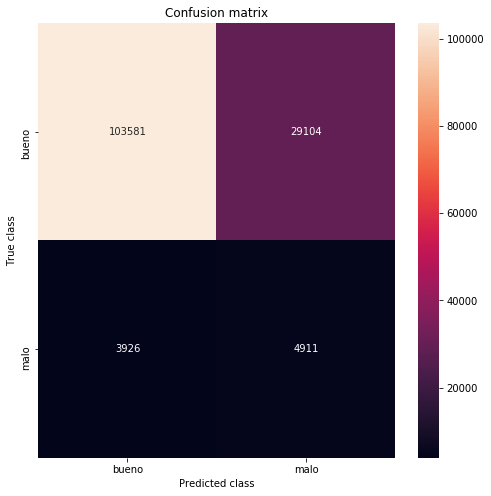

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    132685
           1       0.14      0.56      0.23      8837

    accuracy                           0.77    141522
   macro avg       0.55      0.67      0.55    141522
weighted avg       0.91      0.77      0.82    141522



In [981]:
y_pred = lr.predict(X1)
mostrar_resultados(y1, y_pred)

In [982]:
score = roc_auc_score(y1,y_pred)
print('ROC AUC score:',score)

ROC AUC score: 0.6681925052033204


## PRUEBAS BASE201908

In [831]:
datos3 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF8.xlsx")

In [832]:
pd.value_counts(datos3['FlagCliente'])

BUEN CLIENTE    135478
MAL CLIENTE       9932
Name: FlagCliente, dtype: int64

In [833]:
df_train3=datos3.copy()
#CONVERTIR DATOS Enteros a Categóricos
#df_train['Flag_usoApp'] = df_train['Flag_usoApp'].astype(str) 
#df_train['Flg_sRefinanciamiento201908'] = df_train['Flg_sRefinanciamiento201908'].astype(str)

#df_train['FlagCBCuotasSemestral'] = df_train['FlagCBCuotasSemestral'].astype(str) 
#df_train['FlagCBCuotasAnual'] = df_train['FlagCBCuotasAnual'].astype(str) 
#df_train['FlagCasino'] = df_train['FlagCasino'].astype(str)
#df_train['FlagSaldoCASTIGADO'] = df_train['FlagSaldoCASTIGADO'].astype(str) 

In [834]:
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train3.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train3.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train3.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [835]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train3.loc[df_train3[l].notnull(),l]=df_train3.loc[df_train3[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train3[l].dropna())+list(df_train3[l].dropna()))
    
    df_train3.loc[~df_train3[l].isnull(),l]=me.transform(df_train3.loc[~df_train3[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [837]:
features2

['HabitoPago201907',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201807_201907',
 'HabitoPago201905',
 'NroTransaccionAnual201807_201907',
 'HabitoPago201904',
 'HabitoPago201906',
 'HabitoPago201903',
 'flagdiseftcexterno',
 'HabitoPago201902',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [838]:
features3 =['HabitoPago201908',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201808_201908',
 'HabitoPago201906',
 'NroTransaccionAnual201808_201908',
 'HabitoPago201905',
 'HabitoPago201907',
 'HabitoPago201904',
 'flagdiseftcexterno',
 'HabitoPago201903',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [983]:
y1 = df_train3['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X1 = df_train3.drop(remover, axis=1)

X2 = X1[features3].copy()
y2 = y1.copy()

In [984]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X2.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X2.shape) #tamaño


Valores perdidos por columna
HabitoPago201908                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201808_201908           7106
HabitoPago201906                       0
NroTransaccionAnual201808_201908    7106
HabitoPago201905                       0
HabitoPago201907                       0
HabitoPago201904                       0
flagdiseftcexterno                     0
HabitoPago201903                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(145410, 20)


In [985]:
#X2["SEGMENTONSE"]=X2["SEGMENTONSE"].fillna(value = 6) 
#X2["Flg_usoRCC201908"] = X2["Flg_usoRCC201908"].fillna(value = 0)
X2["ConsumoAnual201808_201908"] = X2["ConsumoAnual201808_201908"].fillna(value = 0)
X2["NroTransaccionAnual201808_201908"] = X2["NroTransaccionAnual201808_201908"].fillna(value = 0)


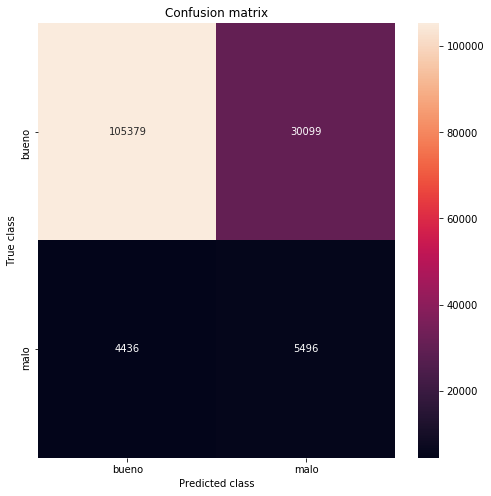

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    135478
           1       0.15      0.55      0.24      9932

    accuracy                           0.76    145410
   macro avg       0.56      0.67      0.55    145410
weighted avg       0.90      0.76      0.82    145410



In [986]:
y_pred = lr.predict(X2)
mostrar_resultados(y2, y_pred)

In [843]:
score = roc_auc_score(y2,y_pred)
print('ROC AUC score:',score)

ROC AUC score: 0.6566374861361841


## base 201905


In [988]:
datos4 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF5.xlsx")

In [989]:
pd.value_counts(datos4['FlagCliente'])

BUEN CLIENTE    129623
MAL CLIENTE       8330
Name: FlagCliente, dtype: int64

In [990]:
df_train4=datos4.copy()
#Tipo de datos 545
feature_columns = {}

feature_columns['categorical'] = df_train4.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train4.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train4.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [991]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train4.loc[df_train4[l].notnull(),l]=df_train4.loc[df_train4[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train4[l].dropna())+list(df_train4[l].dropna()))
    
    df_train4.loc[~df_train4[l].isnull(),l]=me.transform(df_train4.loc[~df_train4[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [992]:
features3

['HabitoPago201908',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201808_201908',
 'HabitoPago201906',
 'NroTransaccionAnual201808_201908',
 'HabitoPago201905',
 'HabitoPago201907',
 'HabitoPago201904',
 'flagdiseftcexterno',
 'HabitoPago201903',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [993]:
features4 = ['HabitoPago201905',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201805_201905',
 'HabitoPago201903',
 'NroTransaccionAnual201805_201905',
 'HabitoPago201902',
 'HabitoPago201904',
 'HabitoPago201901',
 'flagdiseftcexterno',
 'HabitoPago201812',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [994]:
y1 = df_train4['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X1 = df_train4.drop(remover, axis=1)

X2 = X1[features4].copy()
y2 = y1.copy()

In [995]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X2.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X2.shape) #tamaño


Valores perdidos por columna
HabitoPago201905                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201805_201905           6286
HabitoPago201903                       0
NroTransaccionAnual201805_201905    6286
HabitoPago201902                       0
HabitoPago201904                       0
HabitoPago201901                       0
flagdiseftcexterno                     0
HabitoPago201812                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(137953, 20)


In [996]:
#X2["SEGMENTONSE"]=X2["SEGMENTONSE"].fillna(value = 6) 
#X2["Flg_usoRCC201908"] = X2["Flg_usoRCC201908"].fillna(value = 0)
X2["ConsumoAnual201805_201905"] = X2["ConsumoAnual201805_201905"].fillna(value = 0)
X2["NroTransaccionAnual201805_201905"] = X2["NroTransaccionAnual201805_201905"].fillna(value = 0)

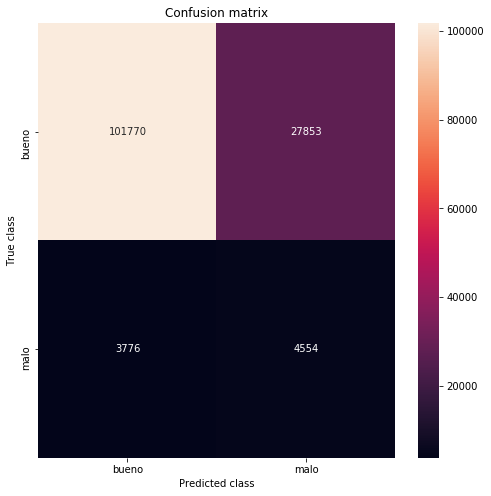

              precision    recall  f1-score   support

           0       0.96      0.79      0.87    129623
           1       0.14      0.55      0.22      8330

    accuracy                           0.77    137953
   macro avg       0.55      0.67      0.54    137953
weighted avg       0.91      0.77      0.83    137953



In [997]:
y_pred = lr.predict(X2)
mostrar_resultados(y2, y_pred)

## base 201904


In [998]:
datos5 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF4.xlsx")

In [999]:
pd.value_counts(datos5['FlagCliente'])

BUEN CLIENTE    134577
MAL CLIENTE       8620
Name: FlagCliente, dtype: int64

In [1000]:
df_train5 = datos5.copy()
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train5.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train5.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train5.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [1001]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train5.loc[df_train5[l].notnull(),l]=df_train5.loc[df_train5[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train5[l].dropna())+list(df_train5[l].dropna()))
    
    df_train5.loc[~df_train5[l].isnull(),l]=me.transform(df_train5.loc[~df_train5[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [1002]:
features5 = ['HabitoPago201904',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201804_201904',
 'HabitoPago201902',
 'NroTransaccionAnual201804_201904',
 'HabitoPago201901',
 'HabitoPago201903',
 'HabitoPago201812',
 'flagdiseftcexterno',
 'HabitoPago201811',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [1003]:
y1 = df_train5['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X1 = df_train5.drop(remover, axis=1)

X2 = X1[features5].copy()
y2 = y1.copy()

In [1004]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X2.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X2.shape) #tamaño

Valores perdidos por columna
HabitoPago201904                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201804_201904           6569
HabitoPago201902                       0
NroTransaccionAnual201804_201904    6569
HabitoPago201901                       0
HabitoPago201903                       0
HabitoPago201812                       0
flagdiseftcexterno                     0
HabitoPago201811                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(143197, 20)


In [1005]:
#X2["SEGMENTONSE"]=X2["SEGMENTONSE"].fillna(value = 6) 
#X2["Flg_usoRCC201908"] = X2["Flg_usoRCC201908"].fillna(value = 0)
X2["ConsumoAnual201804_201904"] = X2["ConsumoAnual201804_201904"].fillna(value = 0)
X2["NroTransaccionAnual201804_201904"] = X2["NroTransaccionAnual201804_201904"].fillna(value = 0)

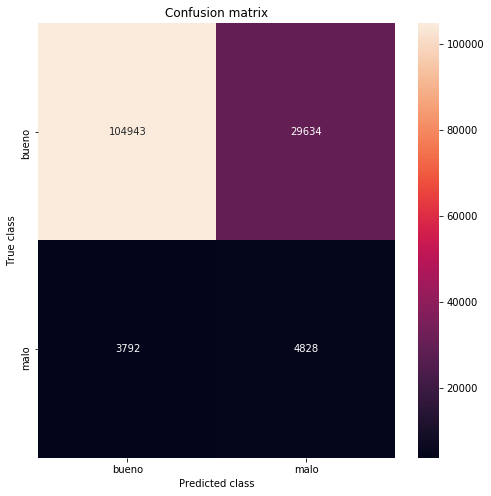

              precision    recall  f1-score   support

           0       0.97      0.78      0.86    134577
           1       0.14      0.56      0.22      8620

    accuracy                           0.77    143197
   macro avg       0.55      0.67      0.54    143197
weighted avg       0.92      0.77      0.82    143197



In [1006]:
y_pred = lr.predict(X2)
mostrar_resultados(y2, y_pred)

In [1007]:
score = roc_auc_score(y2,y_pred)
print('ROC AUC score:',score)

ROC AUC score: 0.6699458664733928


In [1008]:
2* score -1

0.33989173294678565

## BASE 201903


In [1009]:
datos6 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF3.xlsx")

In [1010]:
pd.value_counts(datos6['FlagCliente'])

BUEN CLIENTE    132446
MAL CLIENTE       8349
Name: FlagCliente, dtype: int64

In [1011]:
df_train6 = datos6.copy()
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train6.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train6.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train6.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [1012]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train6.loc[df_train6[l].notnull(),l]=df_train6.loc[df_train6[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train6[l].dropna())+list(df_train6[l].dropna()))
    
    df_train6.loc[~df_train6[l].isnull(),l]=me.transform(df_train6.loc[~df_train6[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [1013]:
features6 = ['HabitoPago201903',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201803_201903',
 'HabitoPago201901',
 'NroTransaccionAnual201803_201903',
 'HabitoPago201812',
 'HabitoPago201902',
 'HabitoPago201811',
 'flagdiseftcexterno',
 'HabitoPago201810',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [1014]:
y1 = df_train6['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X1 = df_train6.drop(remover, axis=1)

X2 = X1[features6].copy()
y2 = y1.copy()

In [1015]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X2.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X2.shape) #tamaño

Valores perdidos por columna
HabitoPago201903                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201803_201903           7017
HabitoPago201901                       0
NroTransaccionAnual201803_201903    7017
HabitoPago201812                       0
HabitoPago201902                       0
HabitoPago201811                       0
flagdiseftcexterno                     0
HabitoPago201810                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(140795, 20)


In [1016]:
#X2["SEGMENTONSE"]=X2["SEGMENTONSE"].fillna(value = 6) 
#X2["Flg_usoRCC201908"] = X2["Flg_usoRCC201908"].fillna(value = 0)
X2["ConsumoAnual201803_201903"] = X2["ConsumoAnual201803_201903"].fillna(value = 0)
X2["NroTransaccionAnual201803_201903"] = X2["NroTransaccionAnual201803_201903"].fillna(value = 0)

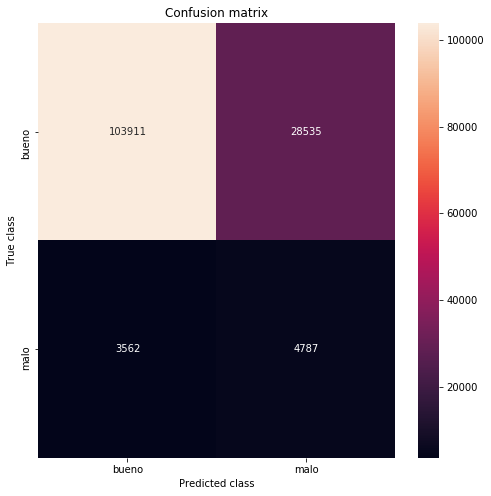

              precision    recall  f1-score   support

           0       0.97      0.78      0.87    132446
           1       0.14      0.57      0.23      8349

    accuracy                           0.77    140795
   macro avg       0.56      0.68      0.55    140795
weighted avg       0.92      0.77      0.83    140795



In [1017]:
y_pred = lr.predict(X2)
mostrar_resultados(y2, y_pred)

# BASE201909

In [1018]:
datos7 = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVF9.xlsx")

In [1019]:
pd.value_counts(datos7['FlagCliente'])

BUEN CLIENTE    145924
MAL CLIENTE       9526
Name: FlagCliente, dtype: int64

In [1020]:
df_train7 = datos7.copy()
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_train7.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_train7.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_train7.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [1021]:
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_train7.loc[df_train7[l].notnull(),l]=df_train7.loc[df_train7[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_train7[l].dropna())+list(df_train7[l].dropna()))
    
    df_train7.loc[~df_train7[l].isnull(),l]=me.transform(df_train7.loc[~df_train7[l].isnull(),l])

    #test.loc[~df_train[l].isnull(),l]=me.transform(df_train.loc[~df_train[l].isnull(),l])
#test=test.drop('FlagCliente', axis=1)

sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [1022]:
features7 = ['HabitoPago201909',
 'FLGRCC',
 'linea_credito_usd',
 'linea_credito_soles',
 'ConsumoAnual201809_201909',
 'HabitoPago201907',
 'NroTransaccionAnual201809_201909',
 'HabitoPago201906',
 'HabitoPago201908',
 'HabitoPago201905',
 'flagdiseftcexterno',
 'HabitoPago201904',
 'flg_usodisef',
 'segmentoNSE',
 'tipo_seguro',
 'nombre_producto',
 'flagpld',
 'zona_apein',
 'flg_situacionlaboral_oscar',
 'edad']

In [1023]:
y1 = df_train7['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X1 = df_train7.drop(remover, axis=1)

X2 = X1[features7].copy()
y2 = y1.copy()

In [1024]:
#Creamos una función:
def num_missing(x):
    return sum(x.isnull()) 
print ("Valores perdidos por columna")
print (X2.apply(num_missing, axis=0)) #axis = 0, columna, num_mising para cada columna cuenta los nulos  
print(X2.shape) #tamaño

Valores perdidos por columna
HabitoPago201909                       0
FLGRCC                                 0
linea_credito_usd                      0
linea_credito_soles                    0
ConsumoAnual201809_201909           7891
HabitoPago201907                       0
NroTransaccionAnual201809_201909    7891
HabitoPago201906                       0
HabitoPago201908                       0
HabitoPago201905                       0
flagdiseftcexterno                     0
HabitoPago201904                       0
flg_usodisef                           0
segmentoNSE                            0
tipo_seguro                            0
nombre_producto                        0
flagpld                                0
zona_apein                             0
flg_situacionlaboral_oscar             0
edad                                   0
dtype: int64
(155450, 20)


In [1025]:
#X2["SEGMENTONSE"]=X2["SEGMENTONSE"].fillna(value = 6) 
#X2["Flg_usoRCC201908"] = X2["Flg_usoRCC201908"].fillna(value = 0)
X2["ConsumoAnual201809_201909"] = X2["ConsumoAnual201809_201909"].fillna(value = 0)
X2["NroTransaccionAnual201809_201909"] = X2["NroTransaccionAnual201809_201909"].fillna(value = 0)

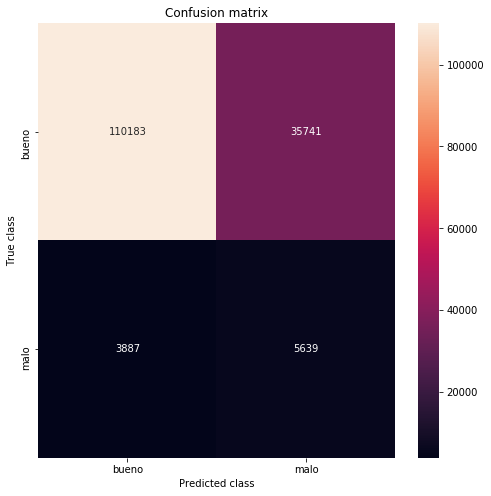

              precision    recall  f1-score   support

           0       0.97      0.76      0.85    145924
           1       0.14      0.59      0.22      9526

    accuracy                           0.75    155450
   macro avg       0.55      0.67      0.53    155450
weighted avg       0.92      0.75      0.81    155450



In [1026]:
y_pred = lr.predict(X2)
mostrar_resultados(y2, y_pred)

### prueba 2

In [1027]:
sklearn.metrics.cohen_kappa_score(y2, y_pred)

0.13541023888740156

In [894]:
datos = pd.read_excel("C:/Users/avelasque/Desktop/cliente/TABLAVP6.xlsx")

In [895]:
100 * datos['FlagCliente'].value_counts() / len(datos['FlagCliente'])

BUEN CLIENTE    96.016889
MAL CLIENTE      3.983111
Name: FlagCliente, dtype: float64

In [896]:
df_t=datos.copy()

In [897]:
#Tipo de datos 
feature_columns = {}

feature_columns['categorical'] = df_t.select_dtypes(include = ['object']).columns.values.tolist()
feature_columns['int'] = df_t.select_dtypes(include = ['integer']).columns.values.tolist()
feature_columns['float'] = df_t.select_dtypes(include = ['float32','float64']).columns.values.tolist()
feature_columns['numerical'] = feature_columns['int'] + feature_columns['float']
feature_columns["categorical"]
del feature_columns["categorical"][-1] #elimino flagcliente

In [898]:
#TRANSFORMACIÓN DE LAS VARIABLES
for l in feature_columns["categorical"] +["FlagCliente"]:
    print(l) 
    me = preprocessing.LabelEncoder()
    
    df_t.loc[df_t[l].notnull(),l]=df_t.loc[df_t[l].notnull(),l].astype(str)
    
    #test.loc[test[l].notnull(),l]=test.loc[test[l].notnull(),l].astype(str)

    
    me.fit(list(df_t[l].dropna())+list(df_t[l].dropna()))
    
    df_t.loc[~df_t[l].isnull(),l]=me.transform(df_t.loc[~df_t[l].isnull(),l])


sexo
estadocivil
departamento
estado
nombre_producto
flg_situacionlaboral_oscar
porc_uso_linea
flg_ppd
flg_usodisef
zona_apein
FLGRCC
segmentoNSE
tipo_seguro
FlagCliente


In [899]:
#Creamos una función:
def num_missing(x):
  return sum(x.isnull())
#Aplicamos por columna:
print ("Valores perdidos por columna")
dict(df_t.apply(num_missing, axis=0)) 
#df_train["TIPO_GRADO"]=df_train["TIPO_GRADO"].fillna(value=5)

Valores perdidos por columna


{'idencuenta': 0,
 'numdoc': 0,
 'sexo': 0,
 'edad': 0,
 'estadocivil': 0,
 'departamento': 0,
 's_fin_estab': 0,
 's_rev_estab': 0,
 's_fin_atm': 0,
 's_rev_atm': 0,
 'saldo_lp': 0,
 'saldo_mora': 0,
 'saldo_exceso': 0,
 'DiasMora201906': 0,
 'estado': 0,
 'nombre_producto': 0,
 'linea_credito_usd': 0,
 'linea_credito_soles': 0,
 'flg_situacionlaboral_oscar': 0,
 'porc_uso_linea': 0,
 'flg_ppd': 0,
 'flg_usodisef': 0,
 'zona_apein': 0,
 'maxlinea_bench': 0,
 'flagscastigado': 0,
 'flagrefinanciado': 0,
 'flagpld': 0,
 'flagdiseftcexterno': 0,
 'FLGRCC': 0,
 'segmentoNSE': 0,
 'ConsumoAnual201806_201906': 1830,
 'NroTransaccionAnual201806_201906': 1830,
 'tipo_seguro': 0,
 'HabitoPago201901': 0,
 'HabitoPago201902': 0,
 'HabitoPago201903': 0,
 'HabitoPago201906': 0,
 'HabitoPago201904': 0,
 'HabitoPago201905': 0,
 'FlagHabitoPago3M': 0,
 'FlagHabitoPago6M': 0,
 'FlagCliente': 0}

In [900]:
df_t["ConsumoAnual201806_201906"]=df_t["ConsumoAnual201806_201906"].fillna(value = 0) 
df_t["NroTransaccionAnual201806_201906"] = df_t["NroTransaccionAnual201806_201906"].fillna(value = 0)

In [901]:
y = df_t['FlagCliente']
remover = ["idencuenta","numdoc",'FlagCliente']#,'HabitoPago201906','HabitoPago201907']
X = df_t.drop(remover, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 1970)

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


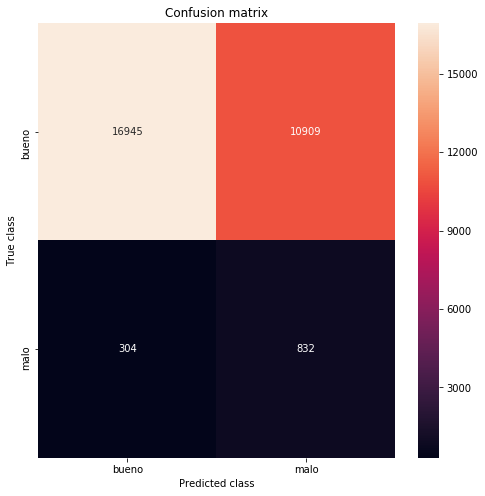

              precision    recall  f1-score   support

           0       0.98      0.61      0.75     27854
           1       0.07      0.73      0.13      1136

    accuracy                           0.61     28990
   macro avg       0.53      0.67      0.44     28990
weighted avg       0.95      0.61      0.73     28990



In [905]:
colsP = X.columns.to_list()
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter= 500, class_weight= "balanced")
logit.fit(X_train, y_train)
 
# Test accuracy
y_pred = logit.predict(X_test)

mostrar_resultados(y_test, y_pred)

In [907]:
colsP

['sexo',
 'edad',
 'estadocivil',
 'departamento',
 's_fin_estab',
 's_rev_estab',
 's_fin_atm',
 's_rev_atm',
 'saldo_lp',
 'saldo_mora',
 'saldo_exceso',
 'DiasMora201906',
 'estado',
 'nombre_producto',
 'linea_credito_usd',
 'linea_credito_soles',
 'flg_situacionlaboral_oscar',
 'porc_uso_linea',
 'flg_ppd',
 'flg_usodisef',
 'zona_apein',
 'maxlinea_bench',
 'flagscastigado',
 'flagrefinanciado',
 'flagpld',
 'flagdiseftcexterno',
 'FLGRCC',
 'segmentoNSE',
 'ConsumoAnual201806_201906',
 'NroTransaccionAnual201806_201906',
 'tipo_seguro',
 'HabitoPago201901',
 'HabitoPago201902',
 'HabitoPago201903',
 'HabitoPago201906',
 'HabitoPago201904',
 'HabitoPago201905',
 'FlagHabitoPago3M',
 'FlagHabitoPago6M']

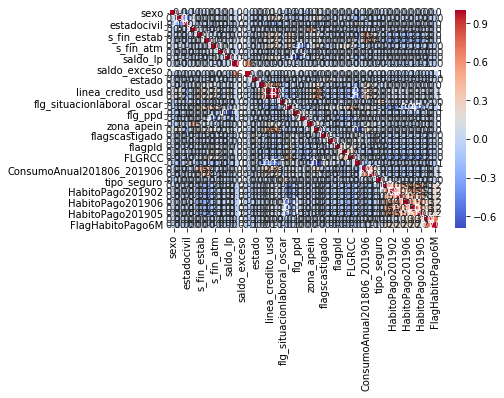

[INFO] filtering variables ...
Variable filtering on 96633 rows and 40 columns in 00:02:38 
12 variables are removed


In [908]:
data = df_t.copy()
sns.heatmap(data[colsP].corr(),annot=True,fmt="0.1f",cmap="coolwarm")
plt.show()
data3 = data[colsP].copy()
data3['FlagCliente'] = data['FlagCliente']

df_data = data3.copy()
df_filter = sc.var_filter(df_data, y="FlagCliente")


In [909]:
# Obtener el information Value por cada variable para conocer la importancia
dt_info_value = sc.iv(df_filter, y = "FlagCliente")
#Se muestra el information value por cada variable en forma descendente
dt_info_value.values

array([['s_fin_atm', 2.2123349979170235],
       ['saldo_lp', 2.0145057637243227],
       ['maxlinea_bench', 1.6844524729905057],
       ['s_rev_estab', 0.9889725169819584],
       ['s_rev_atm', 0.9863877484496726],
       ['s_fin_estab', 0.8053969215750783],
       ['porc_uso_linea', 0.5437274812096526],
       ['linea_credito_usd', 0.5313842688131828],
       ['linea_credito_soles', 0.5313842688131811],
       ['FLGRCC', 0.43983393249599007],
       ['NroTransaccionAnual201806_201906', 0.26390319840259957],
       ['HabitoPago201906', 0.19962549918854092],
       ['flagdiseftcexterno', 0.19560894393160383],
       ['HabitoPago201905', 0.15624971557185818],
       ['flg_usodisef', 0.12759675757700006],
       ['HabitoPago201904', 0.12027933353773398],
       ['HabitoPago201903', 0.10436340662760324],
       ['HabitoPago201902', 0.0954494809791872],
       ['ConsumoAnual201806_201906', 0.09006960297322102],
       ['HabitoPago201901', 0.08155860917679347],
       ['flagpld', 0.07377728

In [916]:
dt_info_ =  dt_info_value[ dt_info_value["info_value"] <= 0.5 ]
cols4 = dt_info_["variable"]
cols4 = cols4.to_list()
features = cols4


In [919]:
#Balanceo
os_us = SMOTETomek( random_state= 3)
X_train_res, y_train_res = os_us.fit_sample(X_train[features], y_train.ravel())

C:\Users\avelasque\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


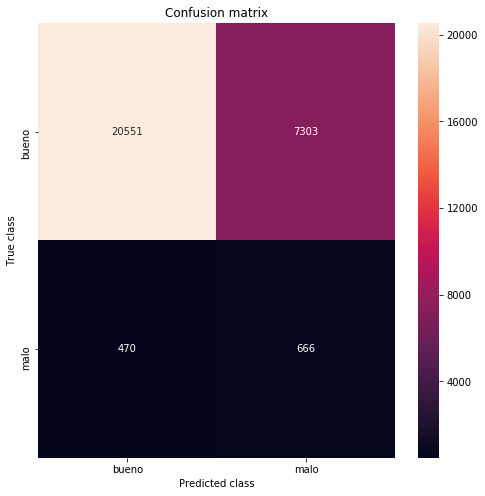

              precision    recall  f1-score   support

           0       0.98      0.74      0.84     27854
           1       0.08      0.59      0.15      1136

    accuracy                           0.73     28990
   macro avg       0.53      0.66      0.49     28990
weighted avg       0.94      0.73      0.81     28990



array([[20551,  7303],
       [  470,   666]], dtype=int64)

In [920]:
from sklearn.linear_model import LogisticRegression
est_boruta = LogisticRegression()
est_boruta.fit(X_train_res, y_train_res)
 
# Test accuracy
y_pred = est_boruta.predict(X_test[features])

mostrar_resultados(y_test, y_pred)
confusion_matrix(y_test, y_pred)